In [1312]:
import numpy as np
import matplotlib.pyplot as plt

### In this notebook, I built a Kalman filter from scratch. I want to estimate the position, velocity and acceleration of a Rocket moving in 1-dimensional space with a noisy (gaussian noise) GPS measurement of its position. The acceleration of the Rocket is constant.

# Simulation - Simulate a Rocket 

In [1313]:
acceleration = np.random.randint(-100, 100)
initial_v = np.random.randint(-100, 100)
initial_x = np.random.randint(-100, 100)

def rocket_movement(t):
    s = initial_x + initial_v * t + acceleration*(t**2)/2
    v = initial_v + acceleration*t
    a = acceleration
    return s, v, a
    
def actual_rocket_state(n):
    s, v, a = rocket_movement(n*h)
    return np.matrix([[s], [v], [a]])

# Kalman Filter

In [1314]:
h = 0.5 # duration of one discrete timestep
duration = 100
sigma = 10 # standard deviation of mesurement (gaussian distribution)

##### The state vector $x = (s, v, a)$ has the entries position, velocity and acceleration. It is important that x is the state vector of the system, and not the position. 
##### Differential equation that describes the dynamics in the continuous case: $\dot{x} = A_{cont}  x$, where $A_{cont} =  \begin{pmatrix}
 0& 1 & 0\\ 
 0& 0 & 1\\ 
 0&0  & 0
\end{pmatrix}$
##### solution: $x(t)=e^{A_{cont}t}x_0$ 
##### for one discrete timestep h: $x_n = e^{A_{cont}  h} x_{n-1}$ 
##### Find matrix representation using series expansion: $ A := e^{A_{cont}  h} = 1 + A_{cont} h + \frac{(A_{cont}h)^2}{2!}+ \dots$= $ \begin{pmatrix}
 1& h & \frac{h^2}{2}\\ 
 0& 1 & h\\ 
 0&0  & 1
\end{pmatrix}$

In [1315]:
# Define A
A = np.array([[1, h,h**2 / 2],[0, 1, h],[0, 0, 1]])

##### The Dynamics equations are:
##### $
 \mathbf{x}_n=A_{n-1} \mathbf{x}_{n-1} $,
 where A is the state dynamics matrix
 
 
$ \mathbf{y}_n=C_n \mathbf{x}_n+\mathbf{v}_n$,
where $y_n$ is the measurement output, $C_n$ is the measurement matrix, and $v_n$ is the measurement noise. 

In [1316]:
# Define C
# We measure the position of the rocket using GPS. Thus, 
C = np.matrix([1, 0, 0]) # multiplied to a state vector, this gives the position only.

In [1317]:
x_0 = np.array([[0],[0],[0]]) # Initial guess of the state

In [1318]:
# Initial covariance matrix. It is the identity matrix
large = 1 # large is a large number, in this way P_0 describes maximum uncertainty about the state.
P_0 = np.matrix(np.eye(3)) * large

In [1319]:
R = np.array([sigma**2]) # covariance matrix of noise

## First step, propagate x and P to priori:

In [1320]:
def propagate_dynamics(x_posteriori_n_minus_1):
    x_priori_n = A @ x_posteriori_n_minus_1
    return x_priori_n

def propagate_P(P_posteriori_n_minus_1):
    P_priori_n = A @ P_posteriori_n_minus_1 @ np.transpose(A)
    return P_priori_n

## Second step, obtain measurement data y_n and compute new priori x and P:

In [1321]:
def calculate_K(P_priori_n): # auxiliary function, K is the Kalman-filter-gain-matrix
    K_n = P_priori_n @ np.transpose(C) @ np.linalg.inv((R + C @ P_priori_n @ np.transpose(C)))
    return K_n

def update_x(x_priori_n, P_priori_n, y_n):
    K_n = calculate_K(P_priori_n)
    x_posteriori_n = x_priori_n + K_n @ (y_n - C @ x_priori_n)
    #print(x_posteriori_n)
    return x_posteriori_n

def update_P(P_priori_n):
    K_n = calculate_K(P_priori_n)
    P_posteriori_n = (np.eye(3) - K_n @ C) @ P_priori_n
    return P_posteriori_n

# Execution

In [1322]:
def Kalman(y_n, x_posteriori_n_minus_1, P_posteriori_n_minus_1):
    x_priori_n = propagate_dynamics(x_posteriori_n_minus_1)
    P_priori_n = propagate_P(P_posteriori_n_minus_1)
    x_posteriori_n = update_x(x_priori_n, P_priori_n, y_n)
    P_posteriori_n = update_P(P_priori_n)
    return x_posteriori_n, P_posteriori_n

estimated_state = []
actual_state = []
for n in range (0, int(duration/h)):
    noise = np.random.normal(0, sigma)
    y_n = C @ actual_rocket_state(n) + noise
    actual_state.append(actual_rocket_state(n))
    if n==0:
        x_posteriori_n, P_posteriori_n = Kalman(y_n, x_0, P_0)
        estimated_state.append(x_posteriori_n)
    else:
        x_priori_n_minus_1, P_priori_n_minus_1 = x_posteriori_n, P_posteriori_n #Shift n by one to get to the next step
        x_posteriori_n, P_posteriori_n = Kalman(y_n, x_priori_n_minus_1, P_priori_n_minus_1)
        estimated_state.append(x_posteriori_n)
        #print(x_posteriori_n)
      
        

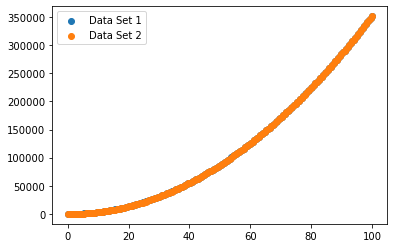

In [1323]:
actual_state = np.array(actual_state) 
estimated_state = np.array(estimated_state)

time = time_array = np.linspace(0, duration, int(duration / h))
actual_position = actual_state[:, 0, 0]
estimated_position = estimated_state[:, 0, 0]

labels = ['Data Set 1', 'Data Set 2']

plt.scatter(time, actual_position)
plt.scatter(time, estimated_position)

plt.legend(labels)
plt.show()

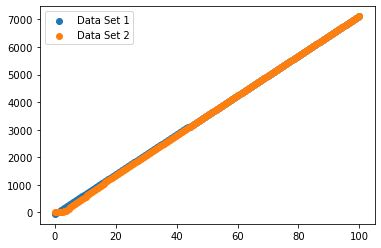

In [1324]:
actual_state = np.array(actual_state) 
estimated_state = np.array(estimated_state)

time = time_array = np.linspace(0, duration, int(duration / h))
actual_velocity = actual_state[:, 1, 0]
estimated_velocity = estimated_state[:, 1, 0]

labels = ['Data Set 1', 'Data Set 2']

plt.scatter(time, actual_velocity)
plt.scatter(time, estimated_velocity)

plt.legend(labels)
plt.show()

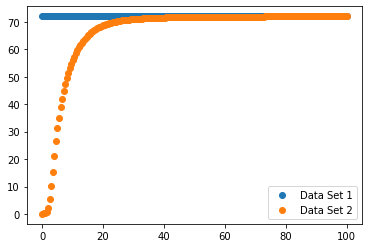

In [1325]:
actual_state = np.array(actual_state) 
estimated_state = np.array(estimated_state)

time = time_array = np.linspace(0, duration, int(duration / h))
actual_acceleration = actual_state[:, 2, 0]
estimated_acceleration = estimated_state[:, 2, 0]

labels = ['Data Set 1', 'Data Set 2']

plt.scatter(time, actual_acceleration)
plt.scatter(time, estimated_acceleration)

plt.legend(labels)
plt.show()